In [1]:
#install and import libraries
%pip install transformers torch
%pip install numpy
%pip install pysbd
#option for BERT score testing
%pip install bert-score

import os
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
import pysbd
import re

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# function to split .txt files into sentences
def split_into_sentences(text):
    segmenter = pysbd.Segmenter(language="en", clean=False)  # clean attr for sequential punct
    sentences = segmenter.segment(text)
    # additional regex pattern splitting to account for wonky early Eng type
    final_sentences = []
    pattern = re.compile(r'(?<=[.!?])\s+(?=[A-Z])')
    for sentence in sentences:
        split_sentences = pattern.split(sentence)
        final_sentences.extend(split_sentences)
    return final_sentences

# gnerate embedds w/ HF BERT
def generate_embeddings_for_files(directory_path):
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model.eval()
    file_embeddings = {}
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):  # account for metadata files in dir
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
            sentences = split_into_sentences(text)
            sentence_embeddings = []
            for sentence in sentences:
                inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
                with torch.no_grad():
                    outputs = model(**inputs)
                    embeddings = outputs.last_hidden_state.squeeze(0).numpy()
                tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
                # variables to average + call embeddings
                word_embeddings = {}
                current_word = ""
                current_embeddings = []
                # concatenate + average subword tokens for full word embeddings
                for token, embedding in zip(tokens, embeddings):
                    if token.startswith("##"):  # detect subwords w/ BERT ## marker
                        current_word += token[2:]
                    else:
                        # average each full word's sub-word components for full word embedding
                        if current_word:
                            word_embeddings[current_word] = np.mean(current_embeddings, axis=0)
                        current_word = token
                        current_embeddings = []
                    current_embeddings.append(embedding)
                # add the last word's embedding
                if current_word:
                    word_embeddings[current_word] = np.mean(current_embeddings, axis=0)
                sentence_embeddings.append((sentence, word_embeddings))
            file_embeddings[filename] = sentence_embeddings
            # msg to check script progress
            print(f'Processed {len(sentences)} sentences from {filename}')
    return file_embeddings

directory_path = "/work/nulab/j.murel/vep_core_drama_1660_v2_txt_mod"
file_embeddings = generate_embeddings_for_files(directory_path)
#save embeddings for txt critical query later
torch.save(file_embeddings, '/work/nulab/j.murel/vep_word_embeddings_sent_alt.pt')

/home/j.murel/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Processed 706 sentences from A00723.headed.txt
Processed 757 sentences from A00725.headed.txt
Processed 975 sentences from A00760.headed.txt
Processed 916 sentences from A00958.headed.txt
Processed 981 sentences from A00960.headed.txt
Processed 486 sentences from A00962.headed.txt
Processed 1132 sentences from A00966.headed.txt
Processed 966 sentences from A00967.headed.txt
Processed 833 sentences from A00968.headed.txt
Processed 1081 sentences from A00969.headed.txt
Processed 971 sentences from A01046.headed.txt
Processed 842 sentences from A01047.headed.txt
Processed 914 sentences from A01049.headed.txt
Processed 807 sentences from A01052.headed.txt
Processed 1059 sentences from A01055.headed.txt
Processed 851 sentences from A01056.headed.txt
Processed 901 sentences from A01057.headed.txt
Processed 436 sentences from A01253.headed.txt
Processed 709 sentences from A01500.headed.txt
Processed 630 sentences from A01502.headed.txt
Processed 451 sentences from A01509.headed.txt
Processed 

In [9]:
# load embeddings
file_embeddings = torch.load('/work/nulab/j.murel/vep_word_embeddings_sent.pt')

# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#function to print embeddings with files and sentences for a word
def print_embeddings_for_word(word, tokenizer, file_embeddings):
    tokens = tokenizer.tokenize(word)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    found_embeddings = False
    #retrieve/print file+text (embedding optional)
    for file, sentences in file_embeddings.items():
        for sentence, word_dict in sentences:
            if word in word_dict:
                embedding = word_dict[word]
                print(f"File: {file}")
                print(f"Sentence: {sentence}")
                #print(f"Embedding: {embedding}\n") #comment out for readability
                found_embeddings = True
    
    if not found_embeddings:
        print(f"No embeddings found for the word: {word}")

# specify word 4 search
query_word = "mohammedan"

# print embeddings of word
print_embeddings_for_word(query_word, tokenizer, file_embeddings)


/home/j.murel/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


File: A07246.headed.txt
Sentence: Ever provided that if she, the said offender, by any reasons, arguments or persuasion, can win and prevail with the said Christian offending with her, to alter his religion, and marry her, that then the winning of a soul to the Mohammedan sect, shall acquit her from all shame, disgrace and punishment whatsoever I lay hold on that clause and challenge from you The privilege of the Law. 
Embedding: [ 6.89883471e-01  4.72514093e-01 -7.72582531e-01 -1.63676941e+00
  5.83369017e-01 -2.75434881e-01  1.68292904e+00  4.39781278e-01
 -1.54396802e-01  9.89495367e-02  4.16239381e-01  5.49929067e-02
 -6.45571232e-01  3.03330451e-01 -4.85811010e-02  1.13024092e+00
  1.52193248e-01  5.88821694e-02 -7.56263614e-01  3.71525586e-01
 -3.26478213e-01 -2.42912978e-01 -2.43852437e-01  5.86130619e-01
  9.88426805e-01  9.96392220e-02  2.81119585e-01  2.44599022e-02
 -6.96447015e-01 -4.93507057e-01 -3.67948771e-01  5.37435889e-01
  2.76151776e-01 -3.39939147e-01  2.64530718e-

In [2]:
#libraries for dimen-redux + plotting
%pip install matplotlib scikit-learn

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


/home/j.murel/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


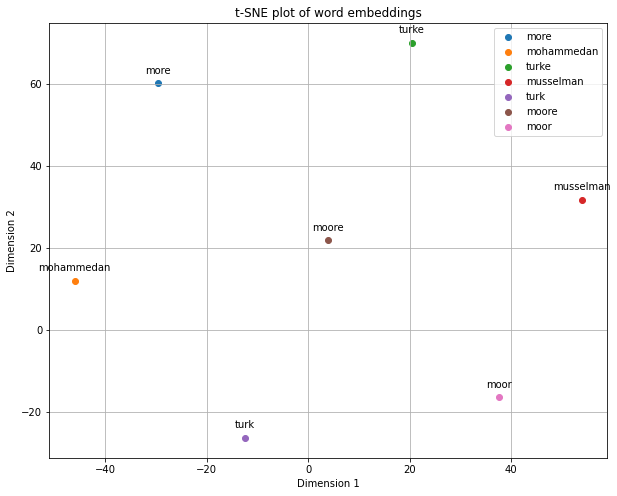

In [6]:
# load embeddings
file_embeddings = torch.load('/work/nulab/j.murel/vep_word_embeddings_sent.pt')

# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# words to plot
words_to_plot = ["more", "mohammedan", "turke", "musselman", "turk", "moore", "moor"]

# function to retrieve all embeddings for word-types, create static embedding from contextual embeddings
def get_embeddings_for_words(words, tokenizer, file_embeddings):
    #list for storing all embeddings of word-type
    word_embeddings = []
    #list for storing each word-type
    word_labels = []
    #tokenize words, convert to tokenIDs, query embeddings
    for word in words:
        tokens = tokenizer.tokenize(word)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        embeddings = []
        for file, sentences in file_embeddings.items():
            for sentence, word_dict in sentences:
                if word in word_dict:
                    embeddings.append(word_dict[word])
        if embeddings:
            # average embeddings for each word-type across different contexts
            avg_embedding = np.mean(embeddings, axis=0)
            word_embeddings.append(avg_embedding)
            word_labels.append(word)
    return np.array(word_embeddings), word_labels

# get specific word embeddings
embeddings, labels = get_embeddings_for_words(words_to_plot, tokenizer, file_embeddings)

# dimen-redux w/ t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# plot
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], label=label)
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()
plt.grid(True)
plt.show()

/home/j.murel/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


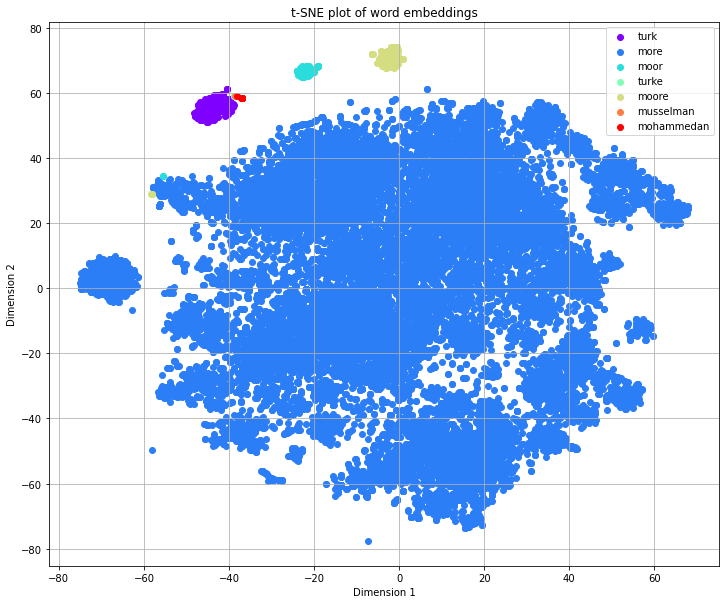

In [7]:
# load embeddings
file_embeddings = torch.load('/work/nulab/j.murel/vep_word_embeddings_sent.pt')

# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# words to plot
words_to_plot = ["more", "mohammedan", "musselman", "turk", "moore", "moor", "turke"]

# function to retrieve all embeddings for each word-type
def get_all_embeddings_for_words(words, tokenizer, file_embeddings):
    #list for storing all embeddings of word-type
    all_embeddings = []
    #list for storing each instances' word-type
    all_labels = []
    #tokenize words, convert to tokenIDs, query embeddings
    for word in words:
        tokens = tokenizer.tokenize(word)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        for file, sentences in file_embeddings.items():
            for sentence, word_dict in sentences:
                if word in word_dict:
                    all_embeddings.append(word_dict[word])
                    all_labels.append(word)
    return np.array(all_embeddings), all_labels

# labels + embedding for specific words via function
embeddings, labels = get_all_embeddings_for_words(words_to_plot, tokenizer, file_embeddings)

# dimen-redux via t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# plot
plt.figure(figsize=(12, 10))
unique_labels = list(set(labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
for i, label in enumerate(unique_labels):
    indices = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, color=colors[i])
plt.legend()
plt.grid(True)
plt.show()

/home/j.murel/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


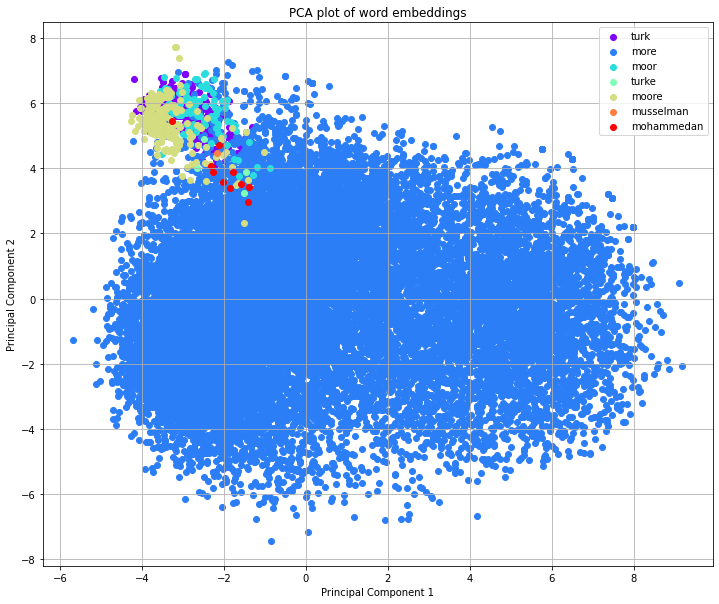

In [8]:
# load embeddings
file_embeddings = torch.load('/work/nulab/j.murel/vep_word_embeddings_sent.pt')

# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# words to plot
words_to_plot = ["more", "mohammedan", "musselman", "turk", "moore", "moor", "turke"]

# function to retrieve all embeddings for each word-type
def get_all_embeddings_for_words(words, tokenizer, file_embeddings):
    #list for storing all embeddings of word-type
    all_embeddings = []
    #list for storing each instance's word-type
    all_labels = []
    #tokenize words, convert to tokenIDs, query embeddings
    for word in words:
        tokens = tokenizer.tokenize(word)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        for file, sentences in file_embeddings.items():
            for sentence, word_dict in sentences:
                if word in word_dict:
                    all_embeddings.append(word_dict[word])
                    all_labels.append(word)
    return np.array(all_embeddings), all_labels

# labels (word-types) + embedding for specific words via function
embeddings, labels = get_all_embeddings_for_words(words_to_plot, tokenizer, file_embeddings)

# dimen-redux via PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# plot
plt.figure(figsize=(12, 10))
unique_labels = list(set(labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    indices = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, color=colors[i])
plt.legend()
plt.grid(True)
plt.show()
